# Newton-Raphson Method Applied to Cost Optimization
## About
This notebook demonstrates the implementation and use of the Newton-Raphson method, applied to a simple logistics problem: minimizing the storage cost of raw materials. 
The notebook shows:
- How to implement the Newton method from scratch in Python.
- How to visualize the iterative process and convergence.
- How to validate results against analytical solutions and `scipy.newton()`.
- Basic automated testing using assertions.

The goal is to illustrate how a **numerical method** can be used to solve a **practical problem** in a small example.

## 1. Theoretical background

### 1.1. Newton-Raphson method
It is an iterative method that can find a root of a function $(f(x) = 0)$, subject to some restrictions, using:
$$
x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}
$$
Where:
- $x_n$ is the current approximation,
- $f(x_n)$ is the function evaluated at $x_n$,
- $f'(x_n)$ is the derivative evaluated at $x_n$,
- $x_{n+1}$ is the next approximation.

**Restrictions:**
- The derivative must not be zero at the current approximation: $f'(x_n) \neq 0$.
- The initial guess $x_0$ should be reasonably close to the true root.
- The function should be differentiable in the region of interest.

### 1.2. Storage Costs Function
We are going to use a storage cost function based on the Economic Order Quantity (EOQ) model for raw materials. This is a perfect example because it's a non-linear function of one variable with practical applications in logistics. 

I simplified the expression to avoid overloading it with algebraic details. 
The core idea is to minimize storage costs over a given period as a function of the lot size ordered: 
$$ C(L) = \frac{a}{L} + b L $$
Where:
- $L$: lot size ordered in the period.
- $a$: ordering-related cost.
- $b$: holding cost.

### 1.3. Analytical Resolution
This is one method to compare results. We can find the optimum of a differentiable function by taking its derivative and setting it equal to zero. The solution of this equation gives the optimum (minimum in our example).

The derivative of the cost function with respect to $L$ is:

$$
\frac{dC}{dL} = -\frac{a}{L^2} + b
$$

Setting the derivative equal to zero to find the optimum:

$$
\frac{dC}{dL} = 0 \quad \Rightarrow \quad -\frac{a}{L^2} + b = 0
$$

Solving for the optimal lot size:

$$
L^* = \sqrt{\frac{a}{b}}
$$


## 2. Implementation
In this section, we first implement the **Newton–Raphson method** described above, and then use it to solve a small business optimization problem.

In [2]:
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt

### 2.1. My own function
Here is the implementation from scratch in Python. 
I used the `sympy` library to manage analytical function expressions and calculate their first derivatives. This allows us to create a reusable function that can find the root of any differentiable function. 

The logic follows what is described above. 
A list is used to save the succession of $x$ values for analyzing convergence later, and error messages are included in case of non-differentiability or non-convergence. 
Additionally, the function handles tolerance and iteration limits.

In [ ]:
def my_newton(f_expr, x0, tol=1e-6, max_iter=20):
    # Auto-detect variable from the expression
    free_syms = list(getattr(f_expr, 'free_symbols', []))
    x = free_syms[0] if free_syms else sp.symbols('x')
    f = sp.lambdify(x, f_expr, 'numpy')
    df = sp.lambdify(x, sp.diff(f_expr, x), 'numpy')

    xn = [x0]

    for _ in range(max_iter):
        if df(xn[-1]) == 0:
            raise ZeroDivisionError("First derivative is zero")
        x_new = xn[-1] - (f(xn[-1]) / df(xn[-1]))
        xn.append(x_new)
        if np.abs(x_new - xn[-2]) < tol:
            return xn

    raise ValueError("Newton method did not converge")

### 2.2. Storage Costs Example
Here is the plot of the cost function.
The goal is to find the point that minimizes total storage cost with respect to lot size $(L)$.

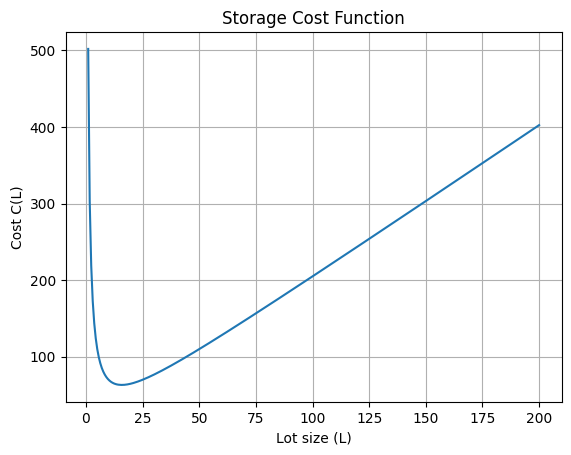

In [4]:
a,b = 500, 2 # parameters

# Analytical definition
L = sp.Symbol('L')
cost_expr = a/L + b*L

# Convert to numerical function
cost = sp.lambdify(L, cost_expr, 'numpy')

L_plot = np.linspace(1, 200, 300)
plt.plot(L_plot, cost(L_plot))
plt.xlabel("Lot size (L)")
plt.ylabel("Cost C(L)")
plt.title("Storage Cost Function")
plt.grid(True)
plt.show()

## 2.3. Applying Newton-Raphson
Now we apply the Newton–Raphson method to find the optimal lot size $L^*$ that minimizes the cost function.
First, we obtain the numerical solution, and then we visualize the iterative process to understand how the method **converges** and **works**.

The first derivative of the cost function is used as the input function for the Newton method, since we are searching for the point where $ \tfrac{dC}{dL} = 0 $. 


### 2.3.1. Numerical Output
We compute the iterations starting from an initial guess $L_0 = 25$.  
The sequence of approximations $L_n$ converges toward the optimum within the specified tolerance.  

| Iteration | 0        | 1       | 2       | 3       | 4       | 5       | 6       | 7       | 8       |
|-----------|----------|---------|---------|---------|---------|---------|---------|---------|---------|
| $L_n$     | 25.0000  | 6.2500  | 8.8867  | 11.9264 | 14.4968 | 15.6519 | 15.8089 | 15.8113 | 15.8113 |
| $C(L_n)$  | 70.000  | 92.500 | 74.037 | 65.777  | 63.484  | 63.249  | 63.246  | 63.246  | 63.246  |

Each value in the table corresponds to an iteration of the Newton–Raphson method approaching the optimal $L^*$, and the corresponding row shows the cost at each iteration.


In [5]:
dcost_expr = sp.diff(cost_expr, L)
x0 = 25

Ln = np.array(my_newton(dcost_expr, x0))
Cn = cost(Ln)

df = pd.DataFrame({
    "L_n": Ln,
    "C(L_n)": Cn
})
df = df.round({"L_n": 6, "C(L_n)": 3})
df.T

,0,1,2,3,4,5,6,7,8
L_n,25.0,6.25,8.886719,11.926443,14.496829,15.651993,15.808986,15.811388,15.811388
C(L_n),70.0,92.50,74.037000,65.777000,63.484000,63.249000,63.246000,63.246000,63.246000


### 2.3.2. Plots
#### Iterations on cost function and convergence behavior
The following plots show how the Newton–Raphson iterations converge to the optimum:
- **Left**: each orange point represents an iteration over the cost function. The sequence gradually approaches the minimum, marked by the dashed green line.
- **Right**: shows the evolution of $L_n$ through iterations, illustrating how the sequence stabilizes near the optimal value.

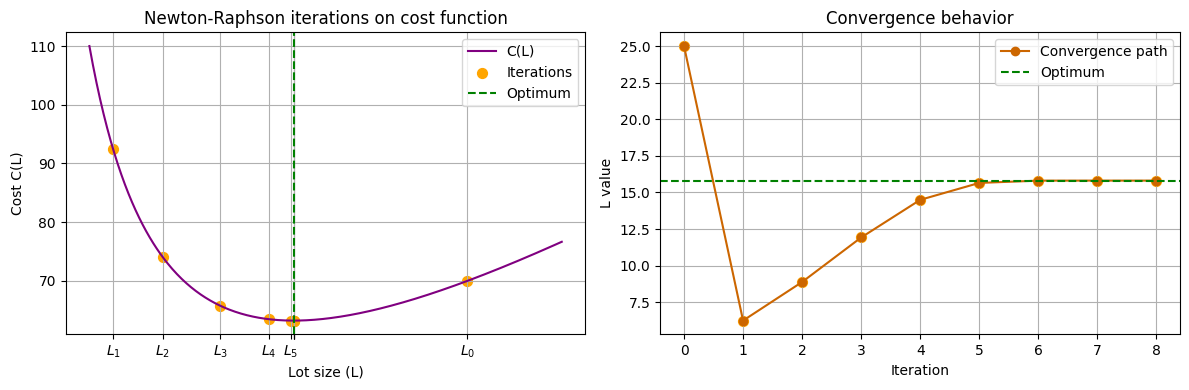

In [6]:
L_plot2 = np.linspace(5,30,400)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left Figure: 
axes[0].plot(L_plot2, cost(L_plot2), color='purple', label='C(L)')
axes[0].scatter(Ln, Cn, color='orange', s=50, label='Iterations')
axes[0].axvline(Ln[-1], color='green', linestyle='--', label='Optimum')
axes[0].set_xticks(Ln)
axes[0].set_xticklabels([f"$L_{i}$" if i < 6 else "" for i in range(len(Ln))])
axes[0].set_xlabel("Lot size (L)")
axes[0].set_ylabel("Cost C(L)")
axes[0].set_title("Newton-Raphson iterations on cost function")
axes[0].legend()
axes[0].grid(True)

# Right Figure:
axes[1].plot(range(len(Ln)), Ln, color='#cc6600', marker='o', label='Convergence path')  
axes[1].scatter(range(len(Ln)), Ln, color='orange', s=50)
axes[1].axhline(Ln[-1], color='green', linestyle='--', label='Optimum')
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("L value")
axes[1].set_title("Convergence behavior")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

#### Newton-Raphson Tangent Illustration
The goal of this plot is to visualize how the method works in practice. 
Here, the function plotted is the derivative of the cost function, $C'(L)$, because the algorithm is searching for its root. 
We focus on the first two iterations, $L_1$ and $L_2$, since they are the most visually clear. \
For notation: 
$$C'(L) := \tfrac{dC}{dL}$$

We can follow how the algorithm proceeds step by step: 
1. It starts from an initial guess, $x_n = L_1$, and evaluates the derivative $C'(L_1)$ at that point. 
2. Then it draws the tangent line at $(L_1, C'(L_1))$ and moves along it until it crosses the horizontal axis. 
3. The x-value or coordinate of that intersection gives the next approximation, $x_{n+1} = L_2$.

This process is repeated iteratively, each time getting closer to the point where $C'(L) = 0$, which corresponds to the minimum of the cost function.

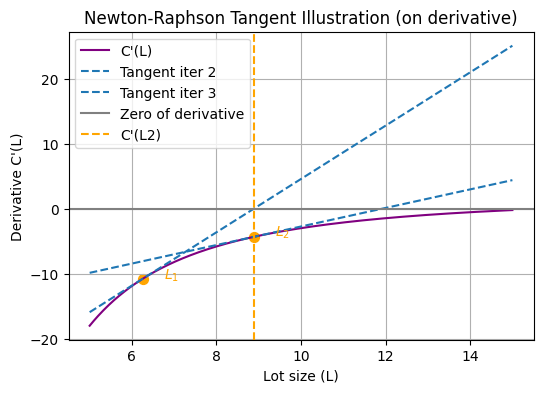

In [7]:
# Tangent illustration (applied to derivative dC/dL)

dC_expr = sp.diff(cost_expr, L)
dC = sp.lambdify(L, dC_expr, 'numpy')

x_vals = np.linspace(5, 15, 400)
y_vals = dC(x_vals)

plt.figure(figsize=(6, 4))
plt.plot(x_vals, y_vals, color='purple', label="C'(L)")

# Tangents for first 2 iterations
for i in range(1,3):
    L_i = Ln[i]
    slope = float(sp.diff(dC_expr, L).evalf(subs={L: L_i}))  # second derivative
    tangent = dC(L_i) + slope * (x_vals - L_i)
    plt.plot(x_vals, tangent, linestyle='--', color='#1f77b4', label=f'Tangent iter {i+1}')
    plt.scatter(L_i, dC(L_i), color='orange', s=50)
    plt.text(L_i + 0.5, dC(L_i) + 0.05, f"$L_{i}$", color='orange')

plt.axhline(0, color='grey', linestyle='-', label='Zero of derivative')
plt.axvline(Ln[2], color='orange', linestyle='--', label='C\'(L2)')

plt.xlabel("Lot size (L)")
plt.ylabel("Derivative C\'(L)")
plt.title("Newton-Raphson Tangent Illustration (on derivative)")
plt.legend()
plt.grid(True)
plt.show()


### 2.3.3. Comparisons
Finally, we compare our results with two other methods: the analytical solution and the built-in `scipy.newton()` implementation.

#### Analytical Resolution
The analytical optimum derived previously is:
$$
L^* = \sqrt{\frac{a}{b}}
$$

In [8]:
L_opt_anlyt = np.sqrt(a / b)
L_opt_my = Ln[-1]

print("Analytical optimum:", L_opt_anlyt)
print("My Newton optimum:", L_opt_my)

# Fast check
assert np.isclose(L_opt_my, L_opt_anlyt, atol=1e-6)

Analytical optimum: 15.811388300841896
My Newton optimum: 15.811388300841868


#### Comparison with `scipy.newton()`

In [9]:
from scipy.optimize import newton

In [10]:
L_opt_scipy = newton(dC, x0)

print("Scipy optimum:", L_opt_scipy)
print("My Newton optimum:", L_opt_my)

# Fast check
assert np.isclose(L_opt_my, L_opt_scipy, atol=1e-6)

Scipy optimum: 15.811388300841896
My Newton optimum: 15.811388300841868


#### Results Summary
| Method            | Optimum L*     |
|-------------------|----------------|
| My Newton         | 15.8113883     |
| Analytical        | 15.8113883     |
| `scipy.newton()`  | 15.8113883     |

#### Conclusion
All methods converge to the same optimum, confirming the accuracy of our Newton-Raphson implementation.

This also validates the analytical result and confirms that our numerical method behaves consistently with `scipy.newton()` within floating-point precision.